# SBU CSE 352 - HW 4 - Machine Learning From Scratch


All student names in group: Henry Lam, Vinty Dong

I understand that my submission needs to be my own group's work: H.L. V.D.

I understand that ChatGPT / Copilot / other AI tools are not allowed: H.L. V.D.

---

## Instructions

Total Points: 100

1. Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy and built-in packages like random). Submit the completely rendered notebook as a HTML file.

  **Important:** Do not use scikit-learn or other packages with ML built in. The point of this is to be a learning exercise. Using linear algebra from numpy is okay (things like matrix operations or pseudoinverse, for example, but not lstsq).

2. Your notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use matplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [1]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2738, done.
remote: Counting objects: 100% (855/855), done.
remote: Compressing objects: 100% (367/367), done.
remote: Total 2738 (delta 523), reused 802 (delta 483), pack-reused 1883
Receiving objects: 100% (2738/2738), 285.30 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (1691/1691), done.
Updating files: 100% (135/135), done.
/content/CS7320-AI/ML
line_fitting.ipynb	ML_example.ipynb	ML_for_tictactoe_self_play.ipynb  README.md
mini-mnist-1000.pickle	ML_for_tictactoe.ipynb	MNIST.ipynb


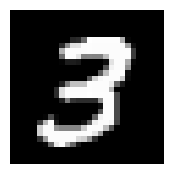

In [2]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

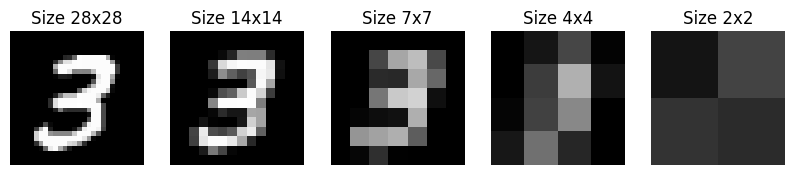

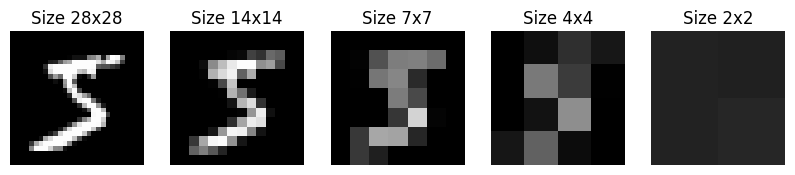

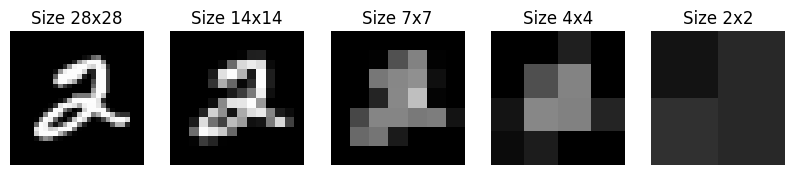

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

### Helper Functions

In [4]:
# Import packages
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize constants
seed = random.seed()
unique_labels, counts = np.unique(labels, return_counts=True)

# Shuffle images for each label
def pre_shuffle(images, labels):
    start, end = 0, 100

    # For each label, shuffle images corresponding to it
    for label, count in zip(unique_labels, counts):
        # Shuffle images and splice it back
        data = images[start:end]
        random.Random(seed).shuffle(data)
        images[start:end] = data

        # Increment ranges for images corresponding to label
        start += count
        end += count

# Split images into train, validation and test
def train_valid_test_split(images, labels, train_ratio, valid_ratio, test_ratio):
    # Calculate indices where we split
    train_end = int(train_ratio * 100)
    valid_end = train_end + int(valid_ratio * 100)
    test_end = valid_end + int(test_ratio * 100)

    # Initialize buckets for data splits
    train_images, train_labels = [], []
    valid_images, valid_labels = [], []
    test_images, test_labels = [], []

    # Simply sample each image list based on
    start, end = 0, 100
    for label, count in zip(unique_labels, counts):
        label_images = images[start : end]

        # Split data into corresponding buckets
        train_images.extend(label_images[ : train_end])
        train_labels.extend([label] * train_end)

        valid_images.extend(label_images[train_end : valid_end])
        valid_labels.extend([label] * (valid_end - train_end))

        test_images.extend(label_images[valid_end : test_end])
        test_labels.extend([label] * (test_end - valid_end))

        # Increment ranges for images corresponding to label
        start += count
        end += count

    return (train_images, train_labels,
            valid_images, valid_labels,
            test_images, test_labels)

def post_shuffle(images, labels):
    # Zip two lists together and shuffle them
    zipped = list(zip(images, labels))
    random.Random(seed).shuffle(zipped)
    images, labels = (zip(*zipped))
    npImages = np.array(list(images))
    npLabels = np.array(list(labels))

    return npImages, npLabels

def display_image(image):
    im = plt.imshow(image, cmap='Greys')
    plt.show()

def resize_images(images, size):
    resized = []

    for image in images:
        downscaled_image = downscale_image(image, size)
        resized.append(downscaled_image)

    return np.array(resized)

def flatten_images(images):
    flat_images = np.reshape(images, (images.shape[0], -1))
    return flat_images

In [5]:
# initialize data split ratios
train_ratio, valid_ratio, test_ratio = 0.8, 0.1, 0.1

# pre-shuffle our dataset
pre_shuffle(images, labels)

# split our data set into train, valid, and test
train_images, train_labels, \
valid_images, valid_labels, \
test_images, test_labels = train_valid_test_split(images, labels, train_ratio,
                                                  valid_ratio, test_ratio)
# post-shuffle our dataset
train_images, train_labels = post_shuffle(train_images, train_labels)
valid_images, valid_labels = post_shuffle(valid_images, valid_labels)
test_images, test_labels = post_shuffle(test_images, test_labels)

### Classifier Constants

In [6]:
# Create images of all sizes
sizes = [28, 14, 7, 4, 2]
resized_train_images = defaultdict(list)
resized_valid_images = defaultdict(list)
resized_test_images = defaultdict(list)

for size in sizes:
    # Resize the rest of the sizes with the helper function
    resized_train_images[size] = flatten_images(resize_images(train_images, size))
    resized_valid_images[size] = flatten_images(resize_images(valid_images, size))
    resized_test_images[size] = flatten_images(resize_images(test_images, size))

### One vs Rest Classifiers

In [7]:
# Initialize constants
num_classes = 10

# Initialize weights and biases
ovr_weights = {size : np.random.randn(num_classes, size**2) * 0.1 for size in sizes}
ovr_biases = {size : np.zeros(num_classes) for size in sizes}

# Train our one vs rest classifiers
def one_vs_rest(images, labels, class_label, weights, bias, learning_rate, num_epochs):
    # Normalize our images. The scale from 0 - 255 heavily impacts our gradient
    images = np.divide(images, 255)

    # Create binary labels (positive = matches our class, negative = doesn't match our class)
    binary_labels = np.where(labels == class_label, 1, -1)

    # Calculate and return errors
    def loss_function(weights, bias):
        outputs = np.dot(images, weights) + bias
        errors = binary_labels - outputs
        return errors

    # Take partial derivatives of error function with respect to weights and bias
    def gradient_descent(weights, bias):
        errors = loss_function(weights, bias)
        N = images.shape[0]

        grad_weights = (-2/N) * np.dot(images.T, errors)    # -2/N * Sigma(xi * (actual - predicted)) + Regularization term
        grad_bias = (-2/N) * np.sum(errors)     # # -2/N * Sigma(actual - predicted)
        weights += learning_rate * grad_weights
        bias += learning_rate * grad_bias

        return weights, bias

    # Perform gradient descent epoch times, updating weights and biases
    for _ in range(num_epochs):
        weights, bias = gradient_descent(weights, bias)

    return weights, bias

# Train each classifier
for size in sizes:
    for i in range(num_classes):
        ovr_weights[size][i], ovr_biases[size][i] = one_vs_rest(resized_train_images[size], train_labels, i,
                                                    ovr_weights[size][i], ovr_biases[size][i],
                                                    learning_rate=0.1, num_epochs=100)

# Predict with our one vs rest classifiers
def predict_one_vs_rest(images, labels, weights, biases):
    N = images.shape[0]
    correct = 0

    # Normalize our images. The scale from 0 - 255 heavily impacts our gradient
    images = np.divide(images, 255)

    # We want to test each image
    for image, label in zip(images, labels):
        # We want to test each classifier
        high_score = classifier = 0
        for i in range(num_classes):
            # Calculate scores, update highest score if possible
            score = np.dot(image, weights[i]) + biases[i]

            if score > high_score:
                high_score = score
                classifier = i

        if classifier == label:
            correct += 1

    accuracy = (correct / N) * 100

    return accuracy

# Make predictions with classifiers
for size in sizes:
    print(f"{size} x {size} images")
    train_preds = predict_one_vs_rest(resized_train_images[size], train_labels, ovr_weights[size], ovr_biases[size])
    valid_preds = predict_one_vs_rest(resized_valid_images[size], valid_labels, ovr_weights[size], ovr_biases[size])
    test_preds = predict_one_vs_rest(resized_test_images[size], test_labels, ovr_weights[size], ovr_biases[size])
    print(f"Train accuracy: {train_preds}%")
    print(f"Valid accuracy: {valid_preds}%")
    print(f"Test accuracy: {test_preds}%\n")

28 x 28 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

14 x 14 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

7 x 7 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

4 x 4 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

2 x 2 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%



### One vs One Classifiers

In [8]:
from itertools import combinations

# Initialize constants
num_classifiers = int(10 * (10 - 1) / 2)
class_pairs = list(combinations(range(num_classes), 2))

# Initialize weights and biases
ovo_weights = { \
    size : {pair : np.random.randn(size**2) * 0.01 for pair in class_pairs} \
    for size in sizes}
ovo_biases = { \
    size : {pair : 0 for pair in class_pairs} \
    for size in sizes}

# Filter images and labels by pair
def filter_images_labels(images, labels, pair):
    mask = ((labels == pair[0]) | (labels == pair[1]))
    images = images[mask]
    labels = labels[mask]

    return images, labels

# Train our one vs one classifiers
def one_vs_one(images, labels, pair, weights, bias, learning_rate, num_epochs):
    # Filter images and labels irrelevant to our pair
    images, labels = filter_images_labels(images, labels, pair)

    # Normalize our images. The scale from 0 - 255 heavily impacts our gradient
    images = np.divide(images, 255)

    # Create binary labels (-1 = pair[0], 1 = pair[1])
    binary_labels = np.where(labels == pair[0], -1, 1)

    # Calculate and return errors
    def loss_function(weights, bias):
        outputs = np.dot(images, weights) + bias
        errors = binary_labels - outputs
        return errors

    # Take partial derivatives of error function with respect to weights and bias
    def gradient_descent(weights, bias):
        errors = loss_function(weights, bias)
        N = images.shape[0]

        grad_weights = (-2/N) * np.dot(images.T, errors)    # -2/N * Sigma(xi * (actual - predicted))
        grad_bias = (-2/N) * np.sum(errors)     # # -2/N * Sigma(actual - predicted)
        weights += learning_rate * grad_weights
        bias += learning_rate * grad_bias

        return weights, bias

    # Perform gradient descent epoch times, updating weights and biases
    for _ in range(num_epochs):
        weights, bias = gradient_descent(weights, bias)

    return weights, bias

# Train each classifier
for size in sizes:
    for pair in class_pairs:
        ovo_weights[size][pair], ovo_biases[size][pair] = one_vs_one(resized_train_images[size], train_labels, pair,
                                                                     ovo_weights[size][pair], ovo_biases[size][pair],
                                                                     learning_rate=0.01, num_epochs=100)

# Predict with our one vs rest classifiers
def predict_one_vs_one(images, labels, weights, biases):
    N = images.shape[0]
    correct = 0

    # Normalize our images. The scale from 0 - 255 heavily impacts our gradient
    images = np.divide(images, 255)

    # We want to test each image
    for image, label in zip(images, labels):
        # We want to test all 45 ovo classifiers
        # Create a list for the votes to see which classifier wins. Index = label identified
        votes = [0] * num_classes
        for pair in class_pairs:
            # Calculate scores, update highest score if possible
            score = np.dot(image, weights[pair]) + biases[pair]

            if score < 0:
                votes[pair[0]] += 1
            else:
                votes[pair[1]] += 1

        winner = votes.index(max(votes))
        if winner == label:
            correct += 1

    accuracy = (correct / N) * 100

    return accuracy

# Make predictions with classifiers
for size in sizes:
    print(f"{size} x {size} images")
    train_preds = predict_one_vs_one(resized_train_images[size], train_labels, ovo_weights[size], ovo_biases[size])
    valid_preds = predict_one_vs_one(resized_valid_images[size], valid_labels, ovo_weights[size], ovo_biases[size])
    test_preds = predict_one_vs_one(resized_test_images[size], test_labels, ovo_weights[size], ovo_biases[size])
    print(f"Train accuracy: {train_preds}%")
    print(f"Valid accuracy: {valid_preds}%")
    print(f"Test accuracy: {test_preds}%\n")

28 x 28 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

14 x 14 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

7 x 7 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

4 x 4 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

2 x 2 images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%



### Results

So far I observed that to get 10% accuracy, the multiplier for random weights and the learning rate needs to be small. The number of epochs also need to be big. More specifically, the magnitude of epochs from 0 should be larger than the magnitude of the learning rate from 0. However at a certain magnitude, the results decline. Both classifiers seem to work equally well and I could not seem to improve the accuracies higher than 10 percent.

---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

In [9]:
import numpy as np
from itertools import combinations_with_replacement
from collections import defaultdict

# Initialize sizes and power combinations
sizes = [28, 14, 7, 4, 2]
powers = [0, 1, 2]
power_indices = defaultdict(dict)

# Augment each list of flattened images
def augment_images(flattened_images, power_indices):
    '''
    INPUTS
    flattened_images: nd array of flattened images (see helper functions)
    power_indices: dictionary {size : {power : [combination of indices to create new data]}}
    OUTPUTS
    new_images: nd array of augmented images. Each augmented image is a nd array of all derived features in order
    '''
    # Augment a single image
    def augment_image(flattened_image, power_indices):
        newImage = []

        # Each image is augmented by appending all the augmented features
        for power, indices in power_indices.items():
            if power == 0:
                newImage.append(1)
            if power == 1:
                indices = np.array(indices).T
                res = flattened_image[indices]
                newImage.extend(res)
            if power == 2:
                indices1, indices2 = np.array(indices).T
                res = flattened_image[indices1] * flattened_image[indices2]
                newImage.extend(res)

        newImage = np.array(newImage)
        return newImage

    # Create a list of augmented images
    new_images = []
    for flattened_image in flattened_images:
        new_image = augment_image(flattened_image, power_indices)
        new_images.append(new_image)

    new_images = np.array(new_images)
    return new_images

# Normalize our images since the features aren't in the [0, 255] range anymore
def normalize_images(images):
    # Use Z score normalization
    mean = np.mean(images, axis=1, keepdims=True)
    std = np.std(images, axis=1, keepdims=True)
    images = (images - mean) / (std + 1e-7)

    return images

# Generate all indices combinations for each power
for size in sizes:
    for power in powers:
        if power == 0:
            power_indices[size][power] = [-1]
        if power == 1:
            power_indices[size][power] = list(range(size ** 2))
        if power == 2:
            power_indices[size][power] = list(combinations_with_replacement(range(size ** 2), power))

# Initialize new images
augmented_train_images = defaultdict(list)
augmented_valid_images = defaultdict(list)
augmented_test_images = defaultdict(list)

# Augment images for each size
for size in sizes:
    augmented_train_images[size] = augment_images(resized_train_images[size], power_indices[size])
    augmented_valid_images[size] = augment_images(resized_valid_images[size], power_indices[size])
    augmented_test_images[size] = augment_images(resized_test_images[size], power_indices[size])

In [10]:
import heapq

# Initialize weights and biases
aug_images_size = defaultdict(int)
for size in sizes:
    total = sum(len(power_indices[size][power]) for power in powers)
    aug_images_size[size] = total
aug_ovr_weights = {size : np.random.randn(num_classes, aug_images_size[size]) * 0.0001 for size in sizes}
aug_ovr_biases = {size : np.zeros(num_classes) for size in sizes}

# Train our one vs rest classifiers
def aug_one_vs_rest(images, labels, class_label, weights, bias, lambda_, learning_rate, num_epochs):
    # Normalize images with z-score
    images = normalize_images(images)

    # Create binary labels (positive = matches our class, negative = doesn't match our class)
    binary_labels = np.where(labels == class_label, 1, 0)

    # Calculate and return errors
    def loss_function(weights, bias):
        outputs = np.dot(images, weights) + bias
        errors = binary_labels - outputs
        return errors

    # Take partial derivatives of error function with respect to weights and bias
    def gradient_descent(weights, bias):
        # Calculate errors and weight/bias gradients
        errors = loss_function(weights, bias)
        N = images.shape[0]

        grad_weights = (-2/N) * np.dot(images.T, errors) + (2 * lambda_ * weights)   # -2/N * Sigma(xi * (actual - predicted)) + Regularization term
        grad_bias = (-2/N) * np.sum(errors)     # # -2/N * Sigma(actual - predicted)
        weights += learning_rate * grad_weights
        bias += learning_rate * grad_bias

        return weights, bias

    # Perform gradient descent epoch times, updating weights and biases
    for _ in range(num_epochs):
        weights, bias = gradient_descent(weights, bias)

    return weights, bias

# Predict with our one vs rest classifiers
def predict_aug_one_vs_rest(images, labels, weights, biases):
    N = images.shape[0]
    correct = 0

    # Normalize images with z-score since we have higher powers
    images = normalize_images(images)

    # We want to test each image
    for image, label in zip(images, labels):
        # We want to test each classifier
        high_score = classifier = 0
        heap = []
        for i in range(num_classes):
            # Calculate score and push onto heap
            score = np.dot(image, weights[i]) + biases[i]
            heapq.heappush(heap, (score, i))

        # Check if our prediction is correct
        score, winner = heapq.heappop(heap)
        if winner == label:
            correct += 1

    accuracy = (correct / N) * 100

    return accuracy

# Train each classifier
for size in sizes:
    for i in range(num_classes):
        aug_ovr_weights[size][i], aug_ovr_biases[size][i] = aug_one_vs_rest(augmented_train_images[size], train_labels, i,
                                                                            aug_ovr_weights[size][i], aug_ovr_biases[size][i],
                                                                            lambda_=0.0001, learning_rate=0.0001, num_epochs=15)

# Make predictions with classifiers
for size in sizes:
    print(f"{size} x {size} augmented images")
    train_preds = predict_aug_one_vs_rest(augmented_train_images[size], train_labels, aug_ovr_weights[size], aug_ovr_biases[size])
    valid_preds = predict_aug_one_vs_rest(augmented_valid_images[size], valid_labels, aug_ovr_weights[size], aug_ovr_biases[size])
    test_preds = predict_aug_one_vs_rest(augmented_test_images[size], test_labels, aug_ovr_weights[size], aug_ovr_biases[size])
    print(f"Train accuracy: {train_preds}%")
    print(f"Valid accuracy: {valid_preds}%")
    print(f"Test accuracy: {test_preds}%\n")

28 x 28 augmented images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

14 x 14 augmented images
Train accuracy: 10.0%
Valid accuracy: 10.0%
Test accuracy: 10.0%

7 x 7 augmented images
Train accuracy: 58.875%
Valid accuracy: 56.00000000000001%
Test accuracy: 53.0%

4 x 4 augmented images
Train accuracy: 45.5%
Valid accuracy: 44.0%
Test accuracy: 41.0%

2 x 2 augmented images
Train accuracy: 26.125%
Valid accuracy: 27.0%
Test accuracy: 16.0%



Some interesting observations were that the training time was unusually long depending on the epochs. If I trained over 100 epochs it would take around 6-8 minutes. Another interesting observation is that when I lowered my epochs, I had a higher accuracy percentage. Also if I made my hyperparameters(learning rate, lambda, weights) too high, it wouldn't improve my training accuracy and sometimes it would crash because the numbers got too large or small.

The dangers of looking at a model's final test accuracy and then suggesting changes to improve it is that this will lead to the model being overfit for our data samples. To fix this problem, we should look at a model's test accuracy on the validation data, then suggest changes to improve it such as tuning the hyperparameters or considering different types of models to use.

---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

28 x 28 KNN Average classification time:  2.21019862 s


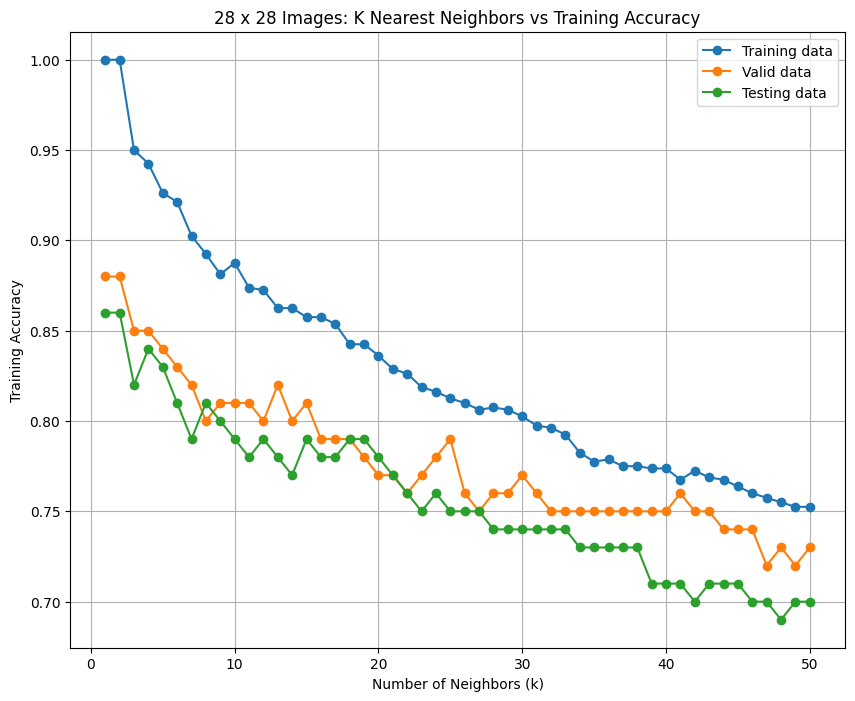

14 x 14 KNN Average classification time:  0.46462732 s


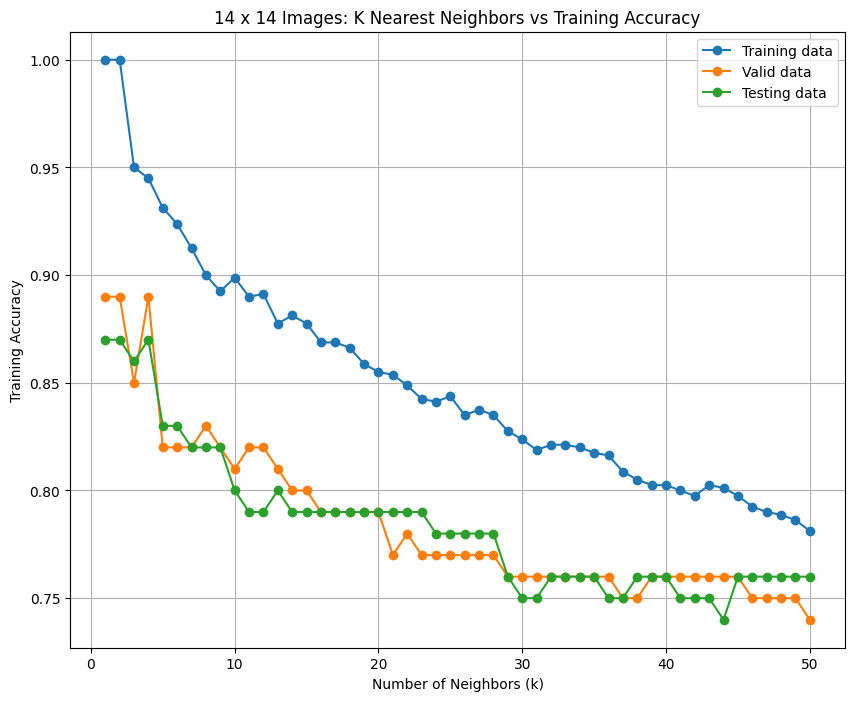

7 x 7 KNN Average classification time:  0.17215988000000002 s


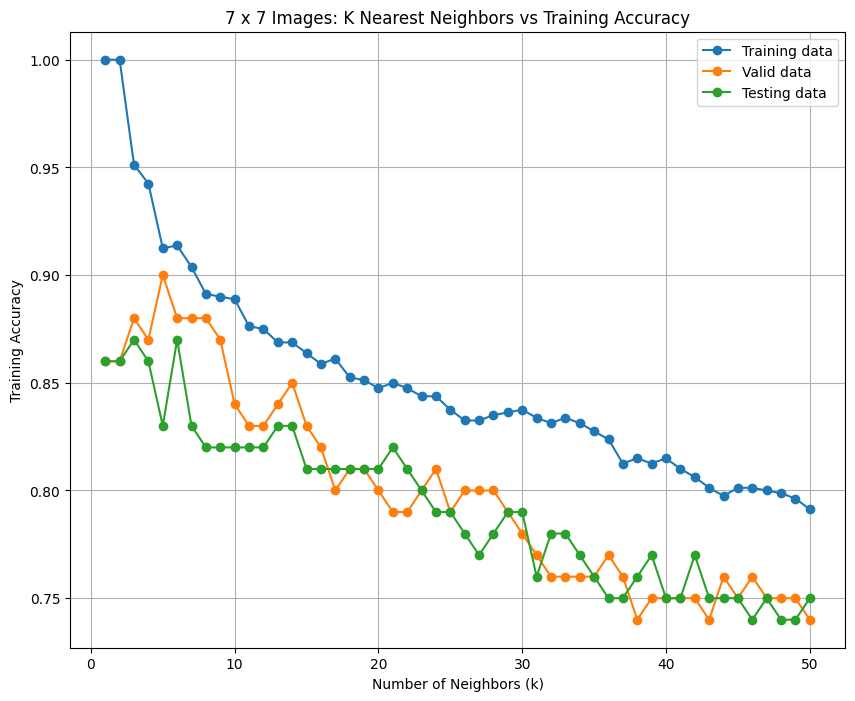

4 x 4 KNN Average classification time:  0.09280842 s


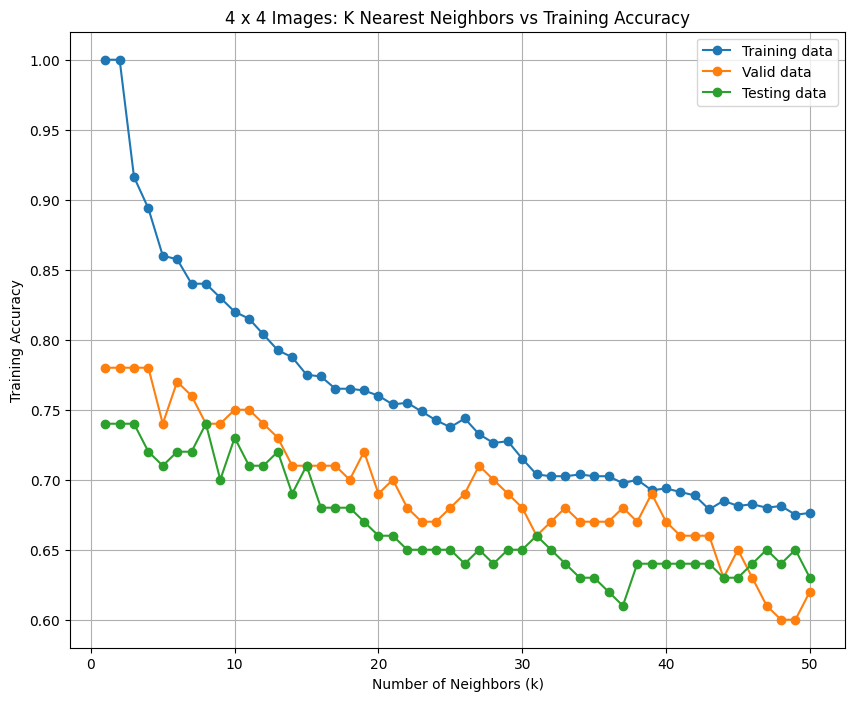

2 x 2 KNN Average classification time:  0.09485189999999999 s


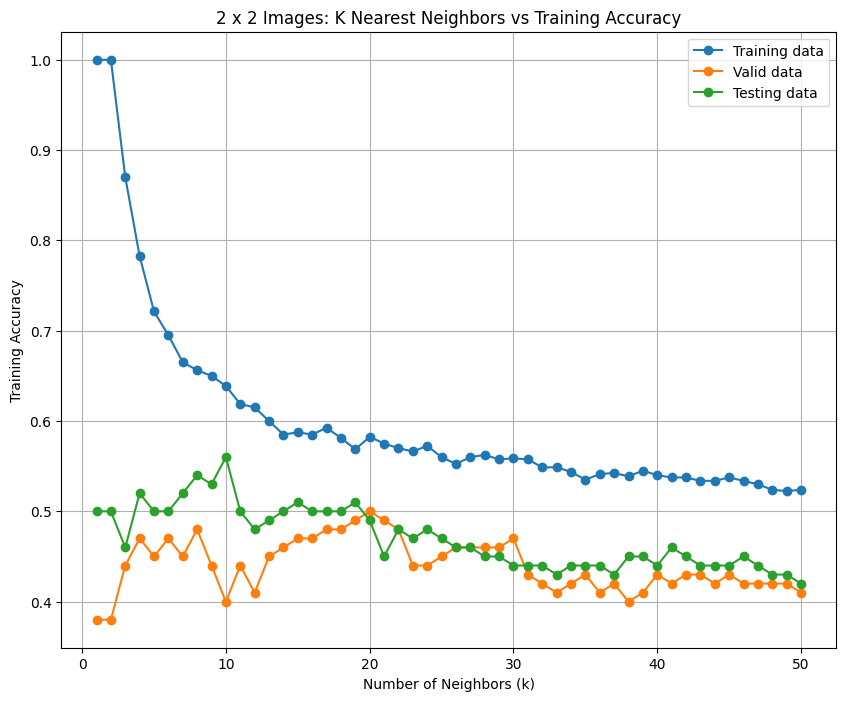

In [11]:
import heapq
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

# Get class of nearest neighbors
def k_nearest_neighbors(train_images, train_labels, image, k):
    '''
    INPUTS
    images: nd array of flattened training images
    labels: nd array of labels corresponding to images
    image: flattened array of image we're trying to classify
    k: number of nearest neighbors we want to consider

    OURPUT:
    winner: the label with the most votes. In the case of a tiebreaker, winner has the smallest distance sum
    '''
    # We want to find the k closest images and labels to the current image
    # Use argpartition to find indices of closest points
    distances = np.sum(np.abs((train_images - image)), axis = 1)
    k_closest_indices = np.argpartition(distances, k)[:k]

    # Map labels and distances associated with closest indices
    votes = defaultdict(list)   # label : list of distances
    for index in k_closest_indices:
        label = train_labels[index]
        distance = distances[index]
        votes[label].append(distance)

    # Find the highest number of votes
    highest_votes = 0
    for distances in votes.values():
        highest_votes = max(highest_votes, len(distances))

    # Find all winners and sort distances using a heap
    winners = []
    for label, distances in votes.items():
        if len(distances) == highest_votes:
            heapq.heappush(winners, (sum(distances), label))
    shortest, winner = heapq.heappop(winners)

    return winner

def predict_knn(train_images, train_labels, test_images, test_labels, k):
    '''
    INPUTS
    train_images: nd array of flattened images to train with
    train_labels: nd array of labels corresponding to train_images
    test_images: nd array of flattened images to test
    test_labels: nd array of labels corresponding to test_images
    k: number of nearest neighbors we want to consider

    OURPUT:
    accuracy: the percentage of correct predictions
    '''
    N = test_images.shape[0]
    correct = 0

    for image, label in zip(test_images, test_labels):
        # We want to feed in the correct training images
        output = k_nearest_neighbors(train_images, train_labels, image, k)
        if output == label:
            correct += 1

    accuracy = (correct / N)

    return accuracy

# Normalize our images. The scale from 0 - 255 heavily impacts our gradient
normalized_train_images = {}
normalized_valid_images = {}
normalized_test_images = {}
for size in sizes:
    normalized_train_images[size] = np.divide(resized_train_images[size], 255)
    normalized_valid_images[size] = np.divide(resized_valid_images[size], 255)
    normalized_test_images[size] = np.divide(resized_test_images[size], 255)

# Predict with our classifier
k_values = list(range(1, 51))
for size in sizes:
    elements = 0
    train_acc, valid_acc, test_acc = ([] for i in range(3))
    start_time = datetime.now()
    for k in k_values:
        elements += normalized_train_images[size].shape[0]
        elements += normalized_valid_images[size].shape[0]
        elements += normalized_test_images[size].shape[0]

        train_acc.append(predict_knn(normalized_train_images[size], train_labels, normalized_train_images[size], train_labels, k))
        valid_acc.append(predict_knn(normalized_train_images[size], train_labels, normalized_valid_images[size], valid_labels, k))
        test_acc.append(predict_knn(normalized_train_images[size], train_labels, normalized_test_images[size], test_labels, k))

    # Calculate average time
    end_time = datetime.now()
    time_difference = (end_time - start_time).total_seconds() * 10**3
    print(f"{size} x {size} KNN Average classification time: ", time_difference/elements, "s")

    # Plot graph
    plt.figure(figsize=(10, 8))
    plt.plot(k_values, train_acc, marker='o', label = 'Training data')
    plt.plot(k_values, valid_acc, marker='o', label = 'Valid data')
    plt.plot(k_values, test_acc, marker='o', label = 'Testing data')
    plt.title(f'{size} x {size} Images: K Nearest Neighbors vs Training Accuracy')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Training Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

---
## Task 4: Neural Networks [40 Points]

Next, your boss wants you to try neural networks. Rather than using a library for everything, you will **only** use `pytorch` to perform backpropagation and compute gradients. You can write your own neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [12]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



### Helper Functions

In [13]:
IMAGE_SIZE = 49
CLASSES = 10

# Create random range to initialize weights
def rand_range(shape, low=-1, high=1):
    return np.random.random(size=shape) * (high - low) + low

# softens class labels to 1-hot repr
# Normally it outputs the labels of the class
# However, we want it to output the binary number of the index of the class instead
def soften(y):
    '''Softens y values to (10,)'''
    identity = np.eye(10)
    return identity[y]

# Initialize weights
def init_weights(layers, layer_size):
    weights = [0] * layers
    weights[0] = torch.tensor(rand_range(shape=(IMAGE_SIZE, layer_size)), requires_grad=True)
    for i in range(1, layers - 1):
        weights[i] = torch.tensor(rand_range(shape=(layer_size, layer_size)), requires_grad=True)
    weights[layers - 1] = torch.tensor(rand_range(shape=(layer_size, CLASSES)), requires_grad=True)
    return weights

# Initialize biases
def init_biases(layers, layer_size):
    biases = [0] * layers
    for i in range(0, layers - 1):
        biases[i] = torch.tensor(rand_range(shape=(layer_size)), requires_grad=True)
    biases[layers - 1] = torch.tensor(rand_range(shape=(CLASSES,)), requires_grad=True)
    return biases

# Normalize our images since the features aren't in the [0, 255] range anymore
def normalize_images(images):
    # Use Z score normalization
    mean = np.mean(images, axis=1, keepdims=True)
    std = np.std(images, axis=1, keepdims=True)
    images = (images - mean) / (std + 1e-7)

    return images

In [14]:
class LogisticNN(torch.nn.Module):
    def __init__(self, layers=2, layer_size=16, activation='sigmoid', learning_rate=0.02):
        # Initialize constants
        self.layers = layers
        self.layer_size = layer_size
        self.learning_rate = learning_rate

        # Initialize weights, biases, and activation function
        self.weights = init_weights(layers, layer_size)
        self.biases = init_biases(layers, layer_size)
        self.activation = getattr(torch, activation)

    def forward(self, x):
        # Calculate activation for all but last layer
        z = torch.tensor(x)
        for i in range(self.layers - 1):
            z = torch.matmul(z, self.weights[i]) + self.biases[i]
            z = self.activation(z)
        # Activation for last layer uses softmax (sigmoid but multiclass)
        # Outputs probability distribution of each number from 0-9)
        z = torch.matmul(z, self.weights[-1])
        z = z + self.biases[-1]
        yhat = torch.softmax(z, dim=1)
        return yhat

    def loss(self, yhat, y):
        return -torch.sum(y * torch.log(yhat))

    def update_params(self):
        with torch.no_grad():
            for w in self.weights:
                w -= self.learning_rate * w.grad
                w.grad.zero_()

            for b in self.biases:
                b -= self.learning_rate * b.grad
                b.grad.zero_()

    def predict(self, x):
        with torch.no_grad():
            return np.argmax(self.forward(x), axis=1)

In [15]:
# Get 7x7 data
train_7 = np.array(resized_train_images[7])
test_7 = np.array(resized_test_images[7])
validate_7 = np.array(resized_valid_images[7])

# Normalize data
# Divide by 255 because values range from 0-255
train_7 = normalize_images(train_7)
test_7 = normalize_images(test_7)
validate_7 = normalize_images(validate_7)

y_train = train_labels
y_validate = valid_labels
y_test = test_labels

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df_rows = []
plot = False
highest_score = [0]

# Model Types
batches = ['full', 'mini']
layers = [2, 3, 4]
layer_size = [16, 32, 64]
activations = ['sigmoid', 'relu', 'tanh']

N = 500 # epochs


softed_ytrain = torch.tensor(soften(y_train))

# Full batch
for layer in layers:
    for nodes in layer_size:
        for act in activations:
            # Train model
            model = LogisticNN(layers=layer, layer_size=nodes, activation=act, learning_rate=0.001)
            losses = np.zeros(N)
            validation_acc = np.zeros(N)

            # Train for N epochs
            for i in range(N):
                yhat = model.forward(train_7)

                loss = model.loss(yhat, softed_ytrain)
                loss.backward()
                model.update_params()

                yhat_validate = np.array(model.predict(validate_7))
                validation_acc[i] = (yhat_validate == y_validate).sum() / y_validate.shape[0]

            yhat_test = np.array(model.predict(test_7))
            testing_acc = (yhat_test == y_test).sum() / y_test.shape[0]
            data = ['full', layer, layer_size, act, validation_acc[-1], testing_acc]
            df_rows.append(data)

            # Record highest score
            if testing_acc > highest_score[-1]:
                highest_score = data

            if plot:
                print(f"Layers: {layer}, Nodes: {layer_size}")
                plt.plot(np.arange(0,N), validation_acc, marker='o')
                plt.title('Validation Accuracy vs. t')
                plt.show()
                plt.plot(np.arange(0,N), losses, marker='o')
                plt.title('Loss vs. t')
                plt.show()

                plot = False

In [28]:
# Dataframe
df = pd.DataFrame(df_rows, columns=['batch', 'layers', 'hidden_dim', 'activation', 'Final Validation Accuracy', 'Testing Accuracy'])
df

# Highest score
print("Highest Score")
hs = pd.DataFrame([highest_score], columns=['batch', 'layers', 'hidden_dim', 'activation', 'Final Validation Accuracy', 'Testing Accuracy'])
hs

Highest Score


,batch,layers,hidden_dim,activation,Final Validation Accuracy,Testing Accuracy
0,full,3,"[16, 32, 64]",sigmoid,0.86,0.9
